In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import numpy as np
from collections import Counter
import pandas as pd
from feedback.plotting import *
from sklearn.metrics import cohen_kappa_score
from scipy.stats import pearsonr


In [3]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')

In [4]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [5]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

In [6]:
style_size = 'paper'

In [7]:
eval_columns = ["inadequate_food","earlier_pickup","donor_problem","recipient_problem","update_contact","system_problem","direction_problem"]
nice_names = ["Inadequate Food", "Earlier Pickup", "Donor Problem", "Recipient Problem", "Update Contact","System Problem", "Direction Problem"]

In [8]:
def get_accuracy(ground_truth,predicted):
    return 1-np.mean(np.abs(predicted-ground_truth))

def get_precision(ground_truth, predicted):
    return np.sum(predicted * ground_truth) / (np.sum(predicted) + 1e-8)

def get_recall(ground_truth, predicted):
    return np.sum(predicted * ground_truth) / (np.sum(ground_truth) + 1e-8)

def get_f1(ground_truth,predicted):
    return 2/(1/get_recall(ground_truth,predicted) + 1/get_precision(ground_truth,predicted))

def convert(x):
    if x is True or str(x).lower() == "true":
        return 1
    elif x is False or str(x).lower() == "false":
        return 0
    elif x in [0, 1]:
        return x
    elif str(x) in ["0", "1"]:
        return int(x)
    else:
        return 0

## Loading Data

In [10]:
pre_deploy_predictions = pd.read_csv("../../data/annotations/pre_deploy_eval.csv")

pre_deploy_annotator_one = pre_deploy_predictions[pre_deploy_predictions['annotator'] == 'naveen'].sort_values(by=['volunteer_comment'])
pre_deploy_annotator_one = pre_deploy_annotator_one[eval_columns]
pre_deploy_annotator_one = np.array(pre_deploy_annotator_one)

pre_deploy_annotator_two = pre_deploy_predictions[pre_deploy_predictions['annotator'] == 'jingwu'].sort_values(by=['volunteer_comment'])
pre_deploy_annotator_two = pre_deploy_annotator_two[eval_columns]
pre_deploy_annotator_two = np.array(pre_deploy_annotator_two)

pre_deploy_array = (pre_deploy_annotator_one+pre_deploy_annotator_two)/2

pre_deploy_predictions = pd.read_csv("../../results/evaluation/{}.csv".format("gpt-4o-mini"))
pre_deploy_predictions[eval_columns] = pre_deploy_predictions[eval_columns].applymap(convert)
pre_deploy_predictions = pre_deploy_predictions.sort_values(by=['volunteer_comment'])
pre_deploy_predictions = pre_deploy_predictions.reset_index(drop=True)
pre_deploy_predictions = np.array(pre_deploy_predictions[eval_columns])

/tmp/ipykernel_745657/762243744.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pre_deploy_predictions[eval_columns] = pre_deploy_predictions[eval_columns].applymap(convert)


In [11]:
post_deploy_annotations = pd.read_csv("../../data/annotations/post_deploy_eval.csv")

post_deploy_annotator_one = post_deploy_annotations[post_deploy_annotations['annotator'] == 'naveen'].sort_values(by=['volunteer_comment'])
post_deploy_annotator_one = post_deploy_annotator_one[eval_columns]
post_deploy_annotator_one = np.array(post_deploy_annotator_one)

post_deploy_annotator_two = post_deploy_annotations[post_deploy_annotations['annotator'] == 'sean'].sort_values(by=['volunteer_comment'])
post_deploy_annotator_two = post_deploy_annotator_two[eval_columns]
post_deploy_annotator_two = np.array(post_deploy_annotator_two)

post_deploy_array = (post_deploy_annotator_one+post_deploy_annotator_two)/2

post_deploy_predictions = pd.read_csv("../../data/annotations/deployment_results.csv")
id_list = post_deploy_annotations[post_deploy_annotations['annotator'] == 'naveen'].sort_values(by=['volunteer_comment'])['id'].tolist()
post_deploy_predictions = post_deploy_predictions.set_index('owner_id').loc[id_list].reset_index()
post_deploy_predictions = np.array(post_deploy_predictions[eval_columns])

In [12]:
instruction_annotations = pd.read_csv("../../data/annotations/direction_rewrite_eval.csv")

instruction_annotator_one = instruction_annotations[instruction_annotations['Annotator'] == 'Naveen'].sort_values(by=['Comment'])
instruction_annotator_one = instruction_annotator_one[['Helpfulness','Novelty','Clarity']]
instruction_annotator_one = np.array(instruction_annotator_one)

instruction_annotator_two = instruction_annotations[instruction_annotations['Annotator'] == 'Jingwu'].sort_values(by=['Comment'])
instruction_annotator_two = instruction_annotator_two[['Helpfulness','Novelty','Clarity']]
instruction_annotator_two = np.array(instruction_annotator_two)

## Evaluation

In [13]:
model_names = ["gpt-4o-mini","gpt-4o","meta-llama_Meta-Llama-3.1-8B-Instruct-Turbo","deepseek-ai_DeepSeek-R1-Distill-Qwen-14B","tf_idf","distilbert"]
nice_names = ["GPT-4o Mini","GPT-4o","Llama 3.1","DeepSeek R1","TF-IDF","BERT"]

data = [] 

pre_deploy_aggregate = np.max(pre_deploy_array,axis=1)

for name in model_names:
    df_eval = pd.read_csv("../../results/evaluation/{}.csv".format(name))
    df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
    df_eval = df_eval.sort_values(by=['volunteer_comment'])
    df_eval = df_eval.reset_index(drop=True)
    df_eval = df_eval[eval_columns]    
    data.append(np.max(np.array(df_eval),axis=1))
accuracies = [get_accuracy(pre_deploy_aggregate,d) for d in data]
precisions = [get_precision(pre_deploy_aggregate,d) for d in data]
recalls = [get_recall(pre_deploy_aggregate,d) for d in data]
f1_scores = [get_f1(pre_deploy_aggregate,d) for d in data]
y_values = [[accuracies,precisions],[recalls,f1_scores]]

y_values = np.array(y_values)
y_values = y_values.reshape((4,6))
y_values = y_values.T
y_values = y_values.flatten().tolist()
y_values = ["{:.1f}".format(j*100)+"\\%" for j in y_values]

/tmp/ipykernel_745657/3175929537.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
/tmp/ipykernel_745657/3175929537.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
/tmp/ipykernel_745657/3175929537.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
/tmp/ipykernel_745657/3175929537.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
/tmp/ipykernel_745657/3175929537.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
/tmp/ipykernel_745657/3175929537.py:10: FutureWarning: DataF

In [14]:
table = """\\textbf{{RescueLens}} & \multicolumn{{5}}{{c}}{{}} \\\\
\\quad +GPT-4o mini &     {}                         &              {}                 &    {}    &  {}    & \\$15.00     \\\\
\\quad +GPT-4o      &      {}                         &              {}                 &    {}    &  {}  &  \\$250.00    \\\\
\\quad +Llama 3.1   &       {}                         &              {}                 &    {}    &  {} & \\$10.00 \\\\
\\quad +DeepSeek R1 &      {}                         &              {}                 &    {}    &  {}   & \\$80.00   \\\\ 
\\cmidrule(lr){{1-6}}
TF-IDF      &  {}                         &              {}                 &    {}    &  {}   & \multicolumn{{1}}{{c}}{{-}}      \\\\
DistilBERT  &  {}                         &              {}                 &    {}    &  {} & \multicolumn{{1}}{{c}}{{-}}   \\\\ \\bottomrule"""
print(table.format(*y_values))

\textbf{RescueLens} & \multicolumn{5}{c}{} \\
\quad +GPT-4o mini &     87.7\%                         &              71.4\%                 &    95.9\%    &  81.9\%    & \$15.00     \\
\quad +GPT-4o      &      90.9\%                         &              77.8\%                 &    95.9\%    &  85.9\%  &  \$250.00    \\
\quad +Llama 3.1   &       81.3\%                         &              61.2\%                 &    97.3\%    &  75.1\% & \$10.00 \\
\quad +DeepSeek R1 &      84.5\%                         &              66.3\%                 &    94.5\%    &  78.0\%   & \$80.00   \\ 
\cmidrule(lr){1-6}
TF-IDF      &  29.0\%                         &              29.0\%                 &    100.0\%    &  44.9\%   & \multicolumn{1}{c}{-}      \\
DistilBERT  &  29.0\%                         &              29.0\%                 &    100.0\%    &  44.9\% & \multicolumn{1}{c}{-}   \\ \bottomrule


In [23]:
ablations = ["gpt-4o-mini","ablation_no_guidelines","ablation_no_few_shot"]
nice_names = ["RescueLens","w/o Guidelines","w/o Few Shot"]

data = [] 
pre_deploy_aggregate = np.max(pre_deploy_array,axis=1)

for name in ablations:
    df_eval = pd.read_csv("../../results/evaluation/{}.csv".format(name))
    df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
    df_eval = df_eval.sort_values(by=['volunteer_comment'])
    df_eval = df_eval.reset_index(drop=True)
    df_eval = df_eval[eval_columns]    
    data.append(np.max(np.array(df_eval),axis=1))
accuracies = [get_accuracy(pre_deploy_aggregate,d) for d in data]
precisions = [get_precision(pre_deploy_aggregate,d) for d in data]
recalls = [get_recall(pre_deploy_aggregate,d) for d in data]
f1_scores = [get_f1(pre_deploy_aggregate,d) for d in data]

/tmp/ipykernel_630397/1169275898.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
/tmp/ipykernel_630397/1169275898.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)
/tmp/ipykernel_630397/1169275898.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_eval[eval_columns] = df_eval[eval_columns].applymap(convert)


In [24]:
accuracies, precisions, recalls, f1_scores

([0.876984126984127, 0.8373015873015873, 0.8452380952380952],
 [0.7142857141399417, 0.64545454533719, 0.6603773583659666],
 [0.9589041093263276, 0.9726027394595609, 0.9589041093263276],
 [0.8187134501008858, 0.7759562839833976, 0.7821229048531569])

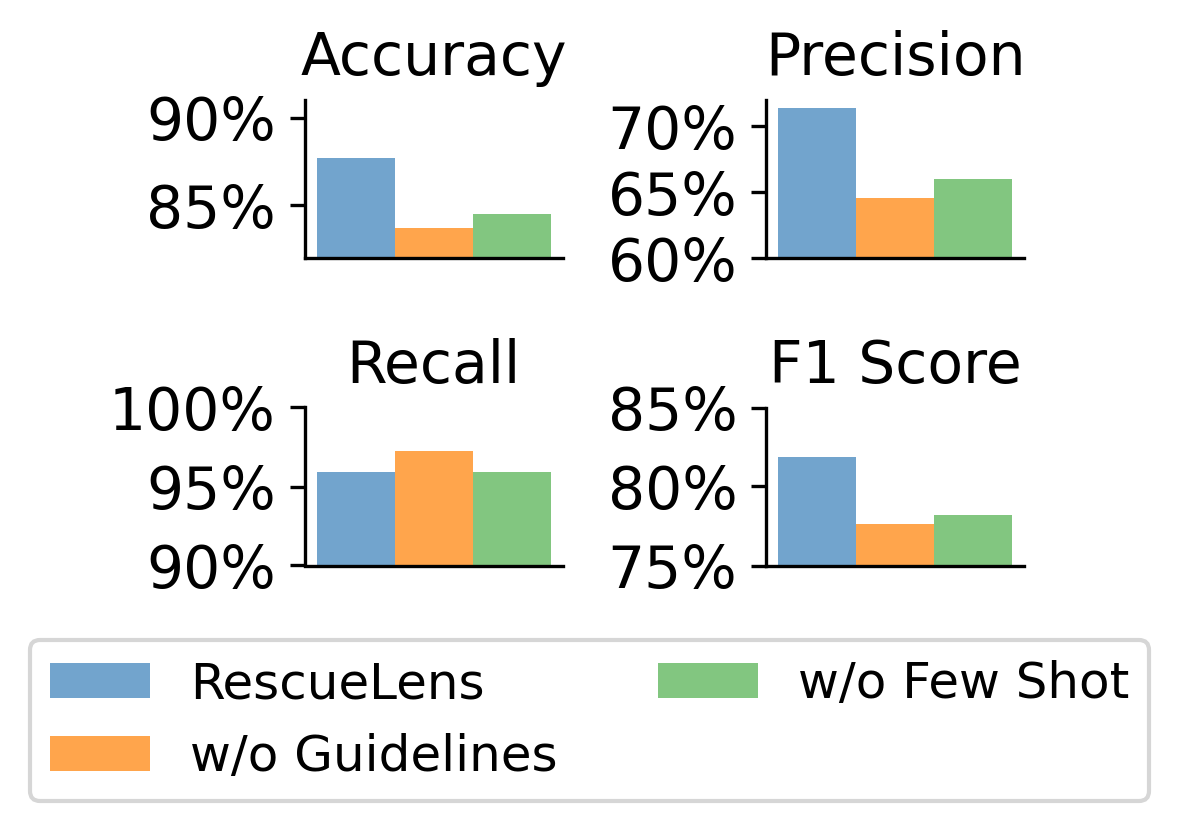

In [28]:
plot_dimensions = (2,2)
x_labels = [["" for i in range(4)],["" for i in range(4)]]
y_labels = [["" for i in range(4)],["" for i in range(4)]]
titles = [["Accuracy","Precision"],["Recall","F1 Score"]]
sup_y_label = ""

overall_format = {'figsize':(3.5, 2.5),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(4)],[[[],[]] for i in range(4)]],
    'y_lim': [[[0.82,0.91],[0.6,0.72]],[[0.9,1],[0.75,0.85]]],
    'y_ticks': [[[[0.85,0.9],["85%","90%"]],[[0.6,0.65,0.7],["60%","65%","70%"]]],[[[0.9,0.95,1],["90%","95%","100%"]],[[0.75,0.8,0.85],["75%","80%","85%"]]]]
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label,titles=titles)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

x_groups = [0,1,2]
y_values = [[accuracies,precisions],[recalls,f1_scores]]
y_errors = [[[0 for i in range(len(accuracies))] for i in range(4)] for i in range(2)]
labels = nice_names

for i in range(2):
    for j in range(2):
        plot_bar(ax[i][j],x_groups,y_values[i][j],y_errors[i][j],nice_names,bar_format)
legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 2, 'bbox_to_anchor': (1.1,0.1)}
create_legend(fig,ax,plot_dimensions,legend_format)
plt.tight_layout()

fig.savefig("../../results/figures/ablations.pdf",dpi=300, bbox_inches='tight')

In [57]:
precisions[0]-precisions[1],precisions[0]-precisions[2]

(0.06883116880275164, 0.053908355773975125)

In [71]:
pre_deploy_aggregate = np.max(pre_deploy_array,axis=1)
pre_deploy_predictions_aggregate = np.max(pre_deploy_predictions,axis=1)


accuracy_aggregate = get_accuracy(pre_deploy_aggregate,pre_deploy_predictions_aggregate)
precision_aggregate = get_precision(pre_deploy_aggregate,pre_deploy_predictions_aggregate)
recall_aggregate = get_recall(pre_deploy_aggregate,pre_deploy_predictions_aggregate)
f1_aggregate = get_f1(pre_deploy_aggregate,pre_deploy_predictions_aggregate)

donor_aggregate = np.max(pre_deploy_array[:,[1,2,6]],axis=1)
donor_predictions_aggregate = np.max(pre_deploy_predictions[:,[1,2,6]],axis=1)
accuracy_donor = get_accuracy(donor_aggregate,donor_predictions_aggregate)
precision_donor = get_precision(donor_aggregate,donor_predictions_aggregate)
recall_donor = get_recall(donor_aggregate,donor_predictions_aggregate)
f1_donor = get_f1(donor_aggregate,donor_predictions_aggregate)

accuracies = [accuracy_aggregate,accuracy_donor]+[get_accuracy(pre_deploy_array[:,i],pre_deploy_predictions[:,i]) for i in range(7)]
precisions = [precision_aggregate,precision_donor] +[get_precision(pre_deploy_array[:,i],pre_deploy_predictions[:,i]) for i in range(7)] 
recalls = [recall_aggregate,recall_donor] +[get_recall(pre_deploy_array[:,i],pre_deploy_predictions[:,i]) for i in range(7)]
f1_scores = [f1_aggregate,f1_donor]+[get_f1(pre_deploy_array[:,i],pre_deploy_predictions[:,i]) for i in range(7)]

y_values = [accuracies,precisions,recalls,f1_scores]

x_vals = [0,1,2,3,4,5,6,7,8]
y_values = np.array(y_values)
y_values = y_values.T
y_values = y_values[x_vals,:]
y_values = y_values.flatten().tolist()
y_values = ["{:.1f}".format(j*100)+"\\%" for j in y_values]

In [72]:
table = """Any Issue   &  {}                       &              {}              &    {}    &  {} \\\\
\\quad Donor Problems   &  {}                      &              {}                &    {}   &  {}  \\\\
\\quad \\quad Inadequate Food      &  {}                       &              {}                &    {}    &  {}    \\\\
\\quad \\quad Earlier Pickup      &  {}                        &            {}                &   {}    &  {}     \\\\
\\quad \\quad Donor Problem      & {}                       &              {}                &    {}    &  {}   \\\\
\\quad Recipient Problem      & {}                        &              {}              &    {}   &  {}     \\\\
\\quad   Update Contact    &  {}                       &              {}               &    {}    &  {}    \\\\
\\quad   System Problem    &  {}                      &             {}               &    {}   & {}     \\\\
\\quad  Direction Problem     &  {}                         &             {}               &    {}   &  {}   """
print(table.format(*y_values))

Any Issue   &  87.7\%                       &              71.4\%              &    95.9\%    &  81.9\% \\
\quad Donor Problems   &  90.5\%                      &              47.5\%                &    86.4\%   &  61.3\%  \\
\quad \quad Inadequate Food      &  93.3\%                       &              70.4\%                &    97.4\%    &  81.7\%    \\
\quad \quad Earlier Pickup      &  99.6\%                        &            83.3\%                &   100.0\%    &  90.9\%     \\
\quad \quad Donor Problem      & 89.3\%                       &              25.0\%                &    72.7\%    &  37.2\%   \\
\quad Recipient Problem      & 96.4\%                        &              56.2\%              &    81.8\%   &  66.7\%     \\
\quad   Update Contact    &  96.8\%                       &              20.0\%               &    100.0\%    &  33.3\%    \\
\quad   System Problem    &  97.2\%                      &             60.0\%               &    66.7\%   & 63.2\%     \\
\quad

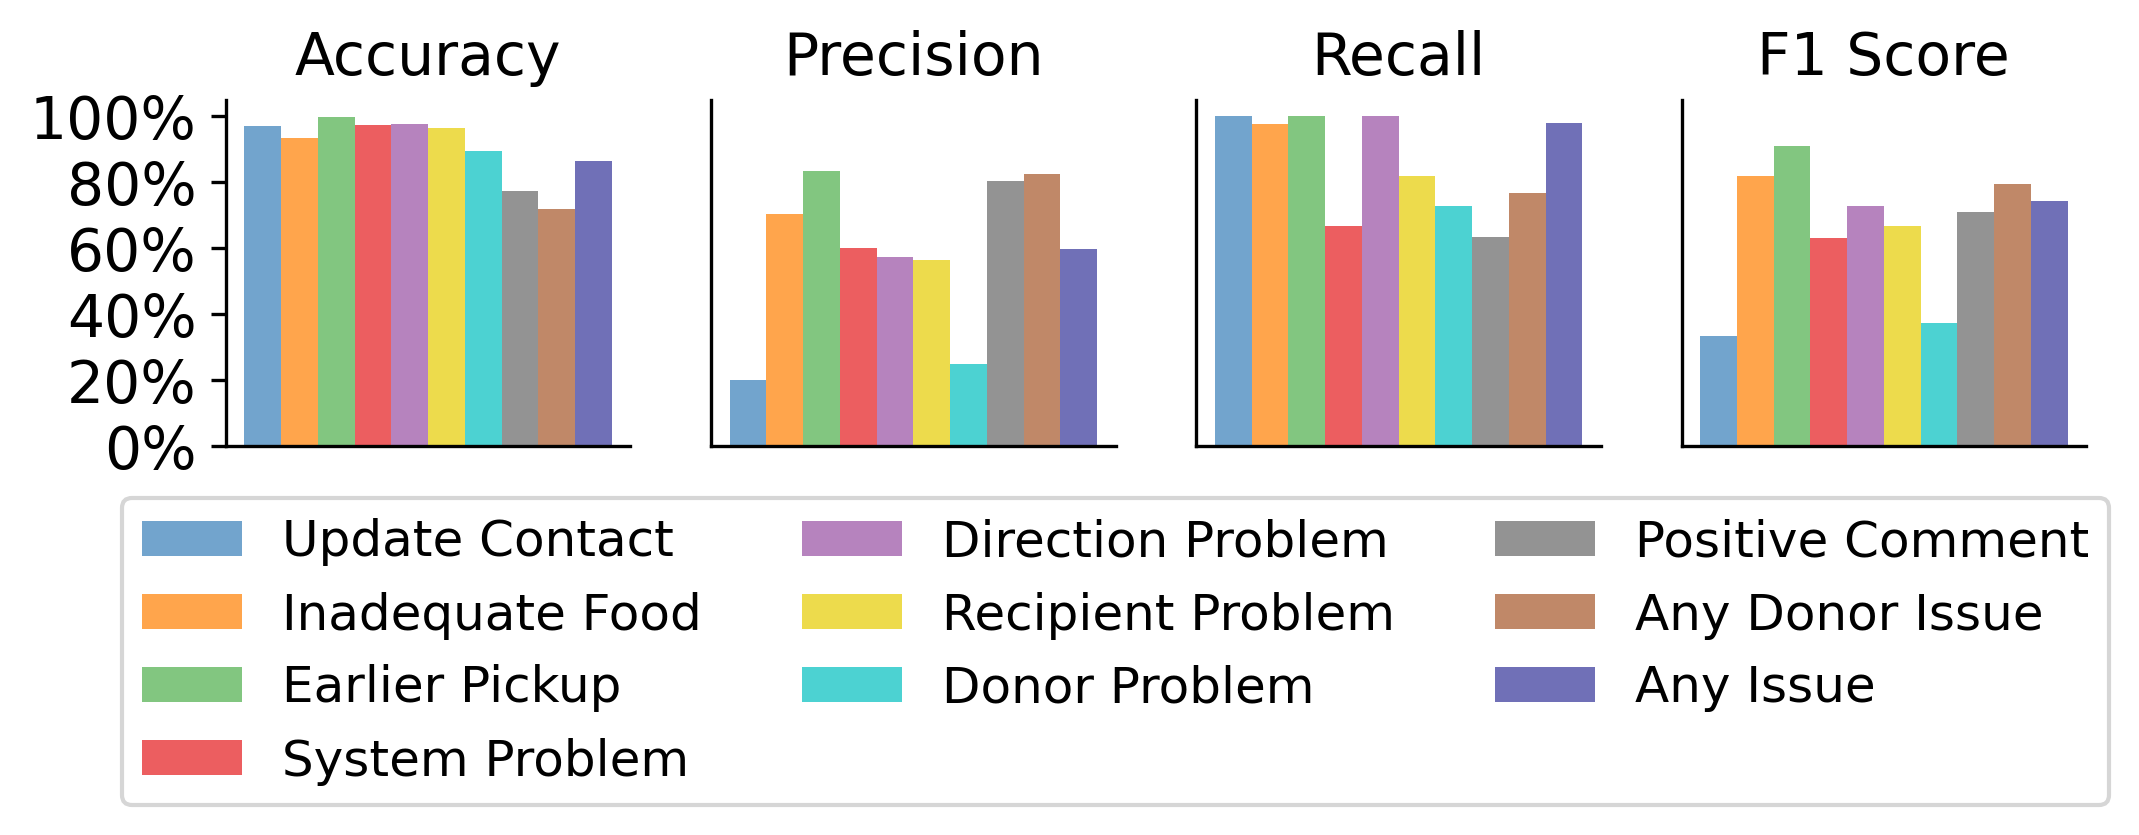

In [17]:
plot_dimensions = (1,4)
x_labels = [["" for i in range(4)]]
y_labels = [["" for i in range(4)]]
titles = [["Accuracy","Precision","Recall","F1 Score"]]
sup_y_label = ""

overall_format = {'figsize':(8, 1.5),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(4)]],
    'y_lim': [[[0,1.05],[0,1.05],[0,1.05],[0,1.05]]],
    'y_ticks': [[[[0,0.2,0.4,0.6,0.8,1],["0%","20%","40%","60%","80%","100%"]],[[],[]],[[],[]],[[],[]]]],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label,titles=titles)

bar_format = {'style_size': style_size,
    'color_palette': 'ten_color'}

x_groups = list(range(10))
y_values = [accuracies,precisions,recalls,f1_scores]
y_errors = [[0 for i in range(len(accuracies))] for i in range(4)]
labels = ["Update Contact","Inadequate Food","Earlier Pickup","System Problem","Direction Problem","Recipient Problem","Donor Problem","Positive Comment"]+["Any Donor Issue","Any Issue"]

for i in range(4):
    plot_bar(ax[0][i],x_groups,y_values[i],y_errors[i],labels,bar_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 3, 'bbox_to_anchor': (0.92,0.05)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/result_comparison.pdf",dpi=300, bbox_inches='tight')

In [21]:
eval_columns

['inadequate_food',
 'earlier_pickup',
 'donor_problem',
 'recipient_problem',
 'update_contact',
 'system_problem',
 'direction_problem']

In [24]:
np.mean(pre_deploy_array[(pre_deploy_predictions[:,2] == 1) & (pre_deploy_array[:,2] == 0)],axis=0)

array([0.1 , 0.  , 0.  , 0.1 , 0.  , 0.05, 0.25])

In [ ]:
average_score = (instruction_annotator_one+instruction_annotator_two)/2
frequency_by_number = [[0 for i in range(9)] for j in range(3)]

for i in range(3):
    for k in range(2,11):
        frequency_by_number[i][k-2] = np.sum(average_score[:,i] == k/2)
frequency_by_number = np.array(frequency_by_number)/30
print(average_score)

In [ ]:
plot_dimensions = (1,3)
x_labels = [["Rating","Rating","Rating"]]
y_labels = [["Frequency","",""]]
titles = [["Helpfulness","Novelty","Clarity"]]
sup_y_label = ""

overall_format = {'figsize':(8, 1.5),
    'style_size': 'presentation',
    'x_ticks': [[[[0,2,4,6,8],[1,2,3,4,5]] for i in range(4)]],
    'y_lim': [[[0,1.05],[0,1.05],[0,1.05],[0,1.05]]],
    'y_ticks': [[[[0,0.25,0.5,0.75,1],["0%","25%","50%","75%","100%"]],[[],[]],[[],[]],[[],[]]]],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label,titles=titles)

bar_format = {'style_size': style_size,
    'color_palette': '#38bae2','bar_width': 1}

x_groups = [0 for i in range(9)]
y_errors = np.zeros(frequency_by_number.shape)
labels = ["" for i in range(9)]

for i in range(3):
    plot_bar(ax[0][i],x_groups,frequency_by_number[i],y_errors[i],labels,bar_format)

fig.savefig("../../results/figures/instruction_eval.pdf",dpi=300, bbox_inches='tight')

## Deployment

In [12]:
donor_dict = json.load(open("../../results/other/donor_categories.json"))
recipient_dict = json.load(open("../../results/other/recipient_categories.json"))
all_comments_2024 = pd.read_csv(open("../../data/annotations/all_2024_with_donors.csv"))
for e in eval_columns:
    all_comments_2024[e] = all_comments_2024[e].map({'f': 0, 't': 1, 'NaN': 0})
all_comments_2024.fillna(0,inplace=True)
volunteer_ratings_2024 = pd.read_csv(open("../../data/annotations/volunteer_ratings_2024.csv"))

ratings = volunteer_ratings_2024.dropna(subset=['volunteer_rating'])

# Step 2: Select relevant columns from comments, including donor and recipient names
comment_cols = [
    'owner_id', 'recipient_problem', 'inadequate_food', 'donor_problem',
    'direction_problem', 'earlier_pickup', 'system_problem',
    'update_contact' ,
    'donor_name', 'recipient_name',  # include these!
]
comments = all_comments_2024[comment_cols].copy()

# Step 3: Merge on owner_id
merged = ratings.merge(comments, on='owner_id', how='left')
merged['donor_name'] = merged['donor_name_x'].combine_first(merged['donor_name_y'])
merged['recipient_name'] = merged['recipient_name_x'].combine_first(merged['recipient_name_y'])

# Drop the old columns
merged = merged.drop(columns=[
    'donor_name_x', 'donor_name_y', 
    'recipient_name_x', 'recipient_name_y'
])

# Step 4: Fill missing problem columns with 0
problem_columns = [
    'recipient_problem', 'inadequate_food', 'donor_problem',
    'direction_problem', 'earlier_pickup', 'system_problem',
    'update_contact'
]
merged[problem_columns] = merged[problem_columns].fillna(0)

# Step 5: Optional - cast to integer for cleanliness
merged[problem_columns] = merged[problem_columns].astype(int)


In [37]:
merged['is_donor_problematic'] = (merged['volunteer_rating'] < 4.0) | merged['update_contact'] | merged['inadequate_food'] | merged['earlier_pickup'] | merged['donor_problem']
merged['donor_comment_score'] = merged['update_contact'] | merged['inadequate_food'] | merged['earlier_pickup'] | merged['donor_problem']

merged['is_recipient_problematic'] = (merged['volunteer_rating'] < 4.0) | merged['update_contact'] | merged['recipient_problem']
merged['recipient_comment_score'] = merged['update_contact'] | merged['recipient_problem']

donor_group = merged.groupby('donor_name').agg(
    volunteer_rating=('volunteer_rating', 'mean'),
    score=('is_donor_problematic','mean'),
    count=('owner_id', 'count'),
    inadequate_food=('inadequate_food','mean'),
    update_contact=('update_contact','mean'),
    earlier_pickup=('earlier_pickup','mean'),
    donor_problem=('donor_problem','mean'),
    comment_score=('donor_comment_score','mean'))
recipient_group = merged.groupby('recipient_name').agg(
    volunteer_rating=('volunteer_rating', 'mean'),
    score=('is_recipient_problematic','mean'),
    count=('owner_id', 'count'),
    comment_score=('recipient_comment_score','mean'),
    update_contact=('update_contact','mean'),
    recipient_problem=('recipient_problem','mean'),
)

# Sort by score descending
donor_group = donor_group.sort_values(by='score', ascending=False).reset_index(drop=True)
recipient_group = recipient_group.sort_values(by='score', ascending=False).reset_index(drop=True)
filtered_donors = donor_group[donor_group['count'] > 100]
filtered_recipients = recipient_group[recipient_group['count'] > 100]

# Sort by score descending
donor_group = donor_group.sort_values(by='score', ascending=False).reset_index(drop=True)
recipient_group = recipient_group.sort_values(by='score', ascending=False).reset_index(drop=True)
filtered_donors = donor_group[donor_group['count'] > 100]
filtered_recipients = recipient_group[recipient_group['count'] > 100]

filtered_donors.to_csv("../../data/annotations/ranked_donors.csv")
filtered_recipients.to_csv("../../data/annotations/ranked_recipients.csv")



0.44782105407495626 0.09037784816745542


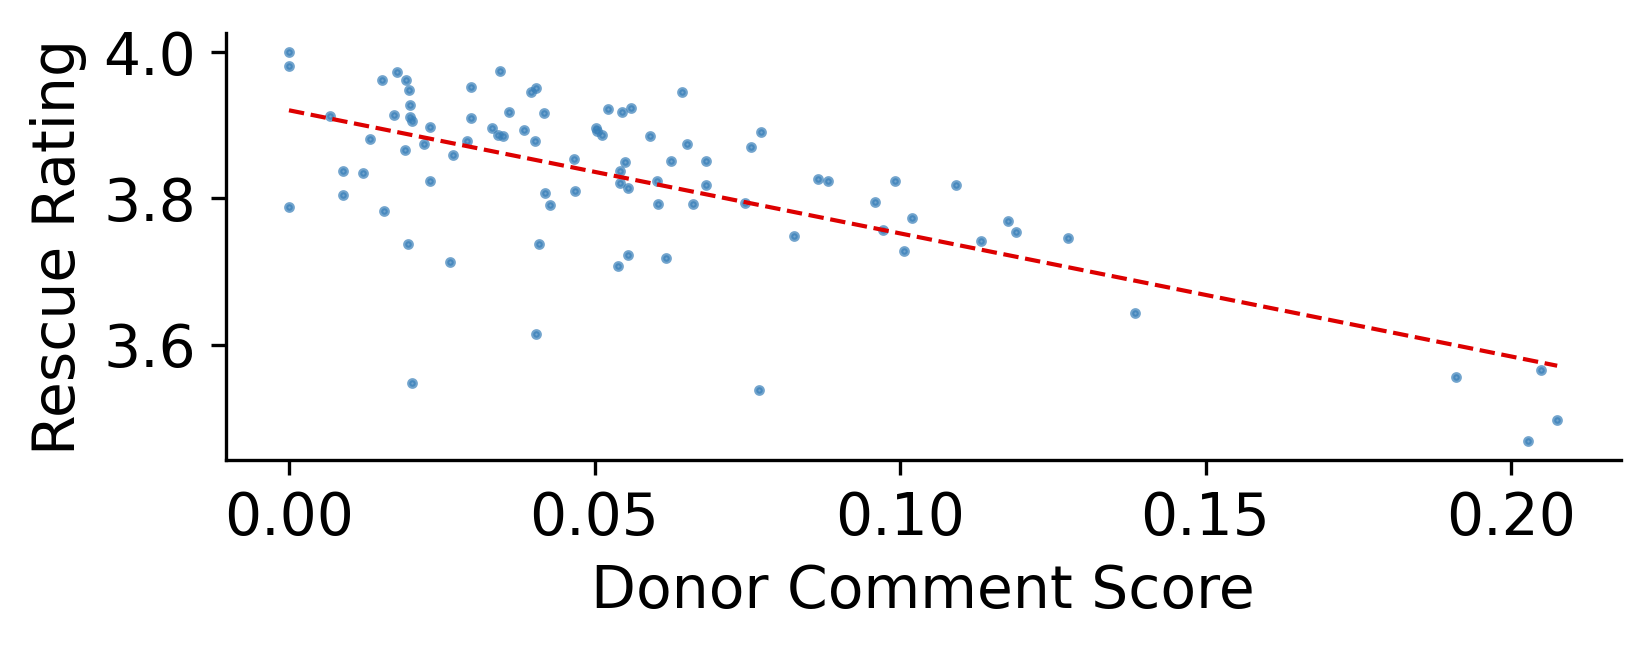

In [27]:
r_donor, _ = pearsonr(filtered_donors['comment_score'],
                      filtered_donors['volunteer_rating'])

r_recipient, _ = pearsonr(filtered_recipients['comment_score'],
                      filtered_recipients['volunteer_rating'])

print(r_donor**2,r_recipient**2)

plot_dimensions = (1,1)
x_labels = [["Donor Comment Score"]]
y_labels = [["Rescue Rating"]]
sup_y_label = ""

overall_format = {'figsize':(6, 1.85),
    'style_size': style_size,
    # 'x_ticks': [[[[],[]] for i in range(1)] for i in range(1)],
    # 'y_lim': [[[0,0.4] for i in range(1)] for j in range(1)], 
    # 'y_ticks': [[[[0,0.2,0.4],["0%","20%","40%"]] for i in range(1)] for i in range(1)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label)

bar_format = {'style_size': style_size,
    'color_palette': 'eight_color', 'size': 10}

x_values = filtered_donors['comment_score']
y_values = filtered_donors['volunteer_rating']
plot_scatter(ax[0][0],[x_values],[y_values],[""],bar_format)

m, b = np.polyfit(x_values, y_values, 1)
plot_line(ax[0][0],[np.linspace(np.min(x_values),np.max(x_values),100)],[m*np.linspace(np.min(x_values),np.max(x_values),100)+b],[[0 for i in range(100)]],[""],
{'style_size': style_size,
    'color_palette': '#DD0000', 'linestyle': 'dashed', 'no_marker': True, 'no_fill': True,'linewidth': 1})

fig.savefig("../../results/figures/donor_comment_score.pdf",dpi=300, bbox_inches='tight')

0.44782105407495626 0.09037784816745542


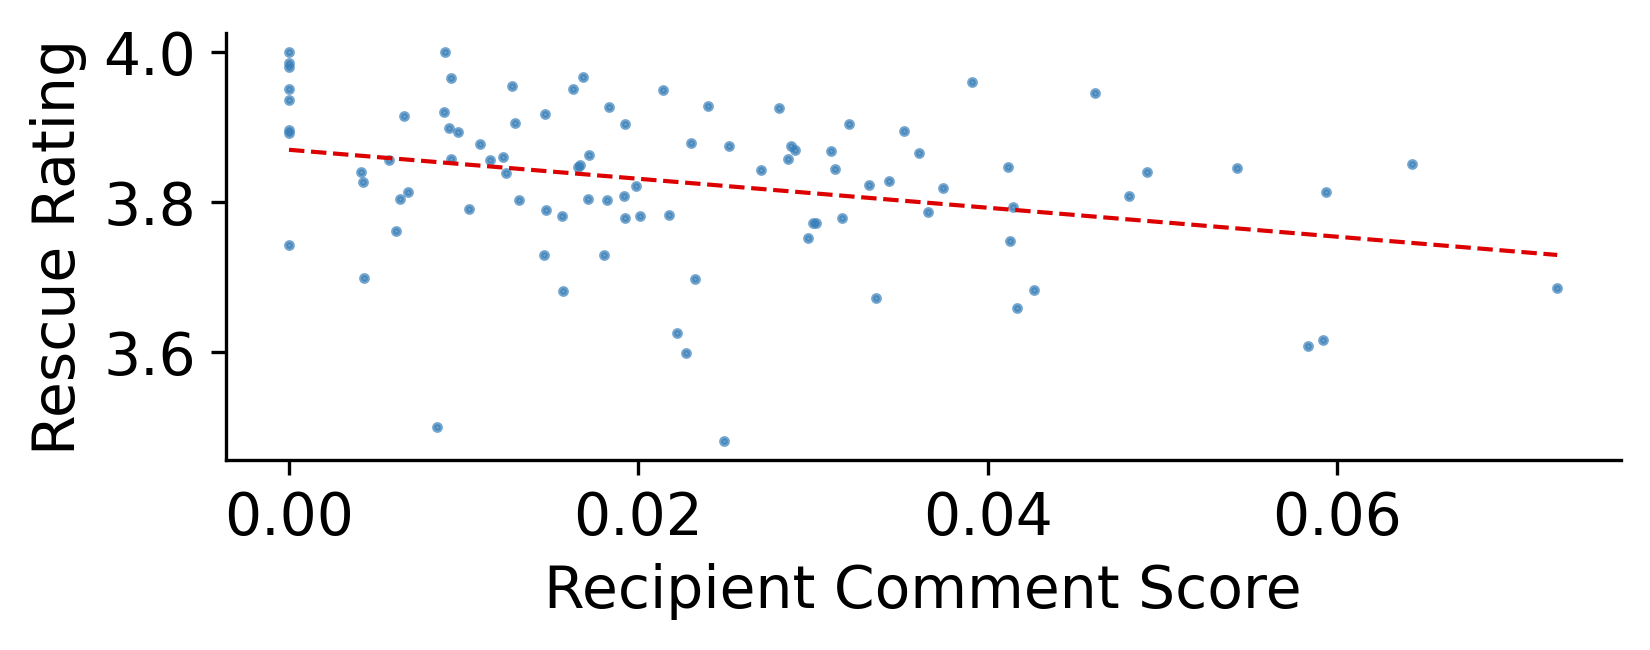

In [28]:
r_donor, _ = pearsonr(filtered_donors['comment_score'],
                      filtered_donors['volunteer_rating'])

r_recipient, _ = pearsonr(filtered_recipients['comment_score'],
                      filtered_recipients['volunteer_rating'])

print(r_donor**2,r_recipient**2)

plot_dimensions = (1,1)
x_labels = [["Recipient Comment Score"]]
y_labels = [["Rescue Rating"]]
sup_y_label = ""

overall_format = {'figsize':(6, 1.85),
    'style_size': style_size,
    # 'x_ticks': [[[[],[]] for i in range(1)] for i in range(1)],
    # 'y_lim': [[[0,0.4] for i in range(1)] for j in range(1)], 
    # 'y_ticks': [[[[0,0.2,0.4],["0%","20%","40%"]] for i in range(1)] for i in range(1)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label)

bar_format = {'style_size': style_size,
    'color_palette': 'eight_color', 'size': 10}

x_values = filtered_recipients['comment_score']
y_values = filtered_recipients['volunteer_rating']
plot_scatter(ax[0][0],[x_values],[y_values],[""],bar_format)

m, b = np.polyfit(x_values, y_values, 1)
plot_line(ax[0][0],[np.linspace(np.min(x_values),np.max(x_values),100)],[m*np.linspace(np.min(x_values),np.max(x_values),100)+b],[[0 for i in range(100)]],[""],
{'style_size': style_size,
    'color_palette': '#DD0000', 'linestyle': 'dashed', 'no_marker': True, 'no_fill': True,'linewidth': 1})

fig.savefig("../../results/figures/recipient_comment_score.pdf",dpi=300, bbox_inches='tight')

0.9318181818181818
0.8602150537634409


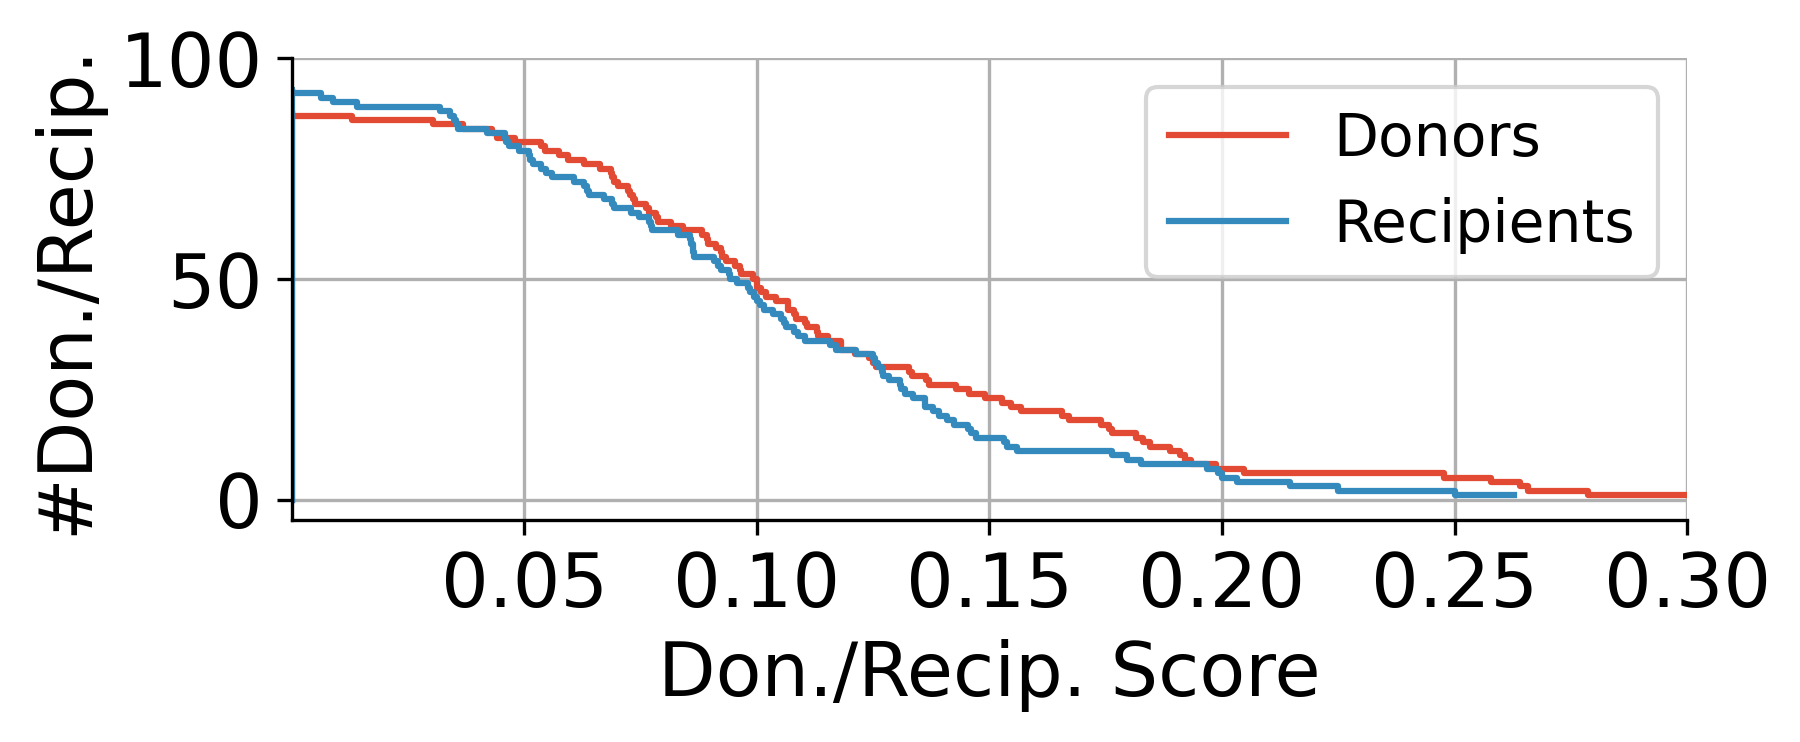

In [32]:
min_threshold = min(filtered_donors['score'].min(),
                    filtered_recipients['score'].min()) - 1e-6
plt.figure(figsize=(6, 2))  # width=6 inches, height=4 inches

for scores, label in [
    (filtered_donors['score'], 'Donors'),
    (filtered_recipients['score'], 'Recipients')
]:
    scores = np.array(scores)
    sorted_scores = np.sort(scores)[::-1]
    thresholds = np.r_[sorted_scores, min_threshold]
    counts = np.arange(1, len(scores)+1)
    print(counts[np.argmax(thresholds<=0.05)]/counts[-1])

    plt.step(thresholds, np.r_[counts, 0], where='post', label=label)

plt.ylabel('#Don./Recip.')
plt.xlabel('Don./Recip. Score')
plt.xlim([0.0001, 0.3])
plt.yticks([0,50,100])
plt.grid(True)
plt.legend()
plt.savefig("../../results/figures/survival_curve_donor.pdf", dpi=300, bbox_inches='tight')


In [38]:
donor_group['inadequate_food_aggregate'] = donor_group['inadequate_food']*donor_group['count']
donor_group['update_contact_aggregate'] = donor_group['update_contact']*donor_group['count']
donor_group['earlier_pickup_aggregate'] = donor_group['earlier_pickup']*donor_group['count']
donor_group['donor_problem_aggregate'] = donor_group['donor_problem']*donor_group['count']

recipient_group['update_contact_aggregate'] = recipient_group['update_contact']*recipient_group['count']
recipient_group['recipient_problem_aggregate'] = recipient_group['recipient_problem']*recipient_group['count']


y_vals = []

for column in ['update_contact_aggregate','inadequate_food_aggregate','earlier_pickup_aggregate','donor_problem_aggregate']:
    sorted_vals = sorted(donor_group[column])
    sorted_vals = [i/sum(donor_group[column]) for i in sorted_vals]
    sorted_vals = sorted_vals[::-1][:5]
    y_vals.append(sorted_vals)
print([sum(i) for i in y_vals])
for column in ['recipient_problem_aggregate']:
    sorted_vals = sorted(recipient_group[column])
    sorted_vals = [i/sum(recipient_group[column]) for i in sorted_vals]
    sorted_vals = sorted_vals[::-1][:5]
    y_vals.append(sorted_vals)

[0.2796208530805687, 0.3828647925033467, 0.3401639344262295, 0.31245166279969067]


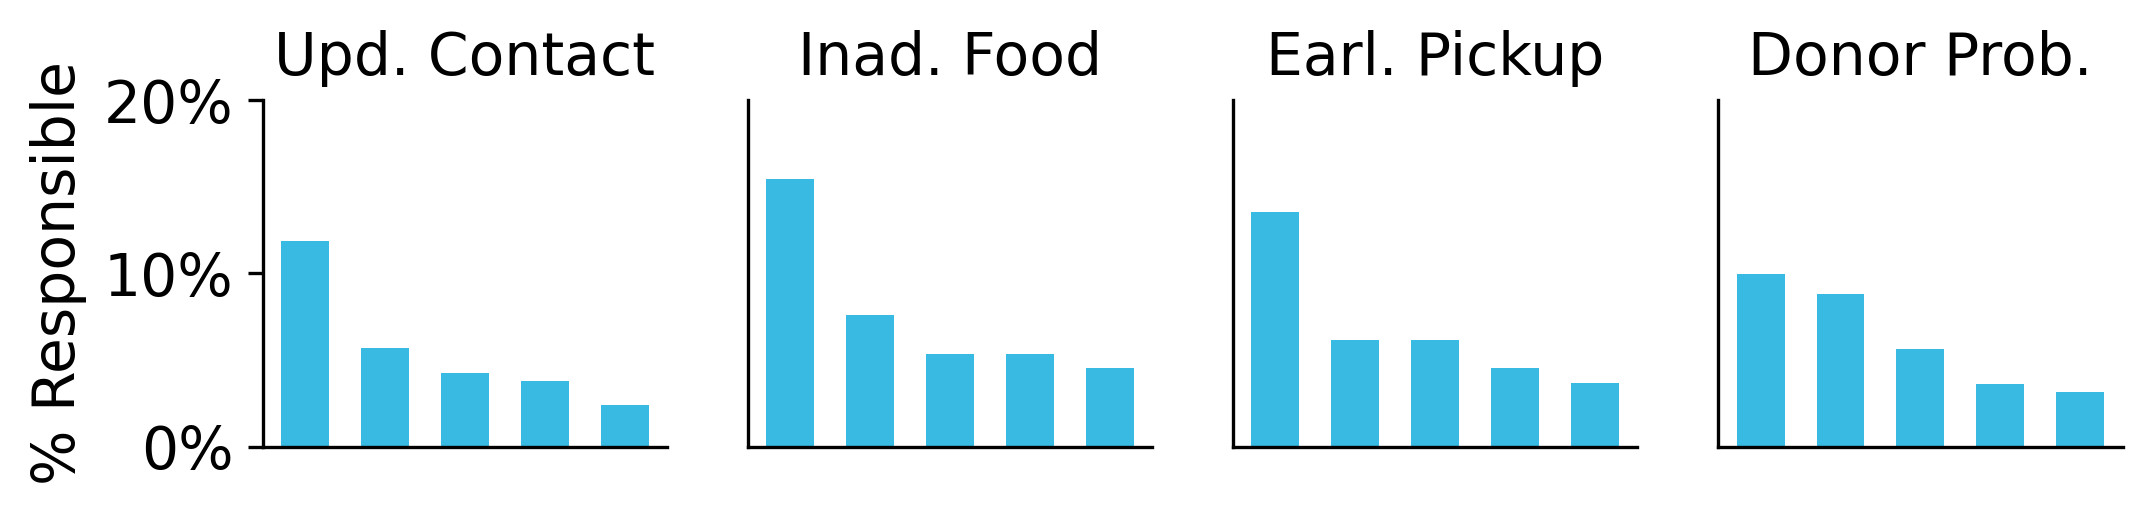

In [40]:
plot_dimensions = (1,4)
issues = ['Upd. Contact','Inad. Food','Earl. Pickup','Donor Prob.']
x_labels = [["" for i in range(5)]]
y_labels = [["% Responsible","","","",""]]
titles = [issues]
sup_y_label = ""

overall_format = {'figsize':(8, 1.5),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(5)]],
    'y_lim': [[[0,0.2],[0,0.2],[0,0.2],[0,0.2],[0,0.2]]],
    'y_ticks': [[[[0,0.1,0.2],["0%","10%","20%"]],[[],[]],[[],[]],[[],[]],[[],[]]]],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label,titles=titles)

bar_format = {'style_size': style_size,
    'color_palette': '#38bae2', 'bar_width': 0.6}

x_groups = [1 for i in range(5)]
y_errors = [[0 for i in range(5)] for i in range(4)]

for i in range(4):
    plot_bar(ax[0][i],x_groups,y_vals[i],[0 for i in range(len(y_vals[i]))],["" for i in range(5)],bar_format)

fig.savefig("../../results/figures/most_impactful_donors.pdf",dpi=300, bbox_inches='tight')